In [62]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import imageio
import geopandas as gpd
from IPython.display import Image, display
import tensorflow as tf
from tensorflow.keras import layers, callbacks, backend, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt
from keras.preprocessing import image

In [63]:
df=pd.read_csv("./methane_224_data/smallsize224_all.csv")

In [64]:
df.shape

(86599, 10)

In [65]:
df.Type.value_counts()

Type
Negative                                        34869
CAFOs                                           25073
WWTreatment                                     14441
Landfills                                        4053
RefineriesAndTerminals                           3961
ProcessingPlants                                 1975
Mines                                            1816
WWTreatment-RefineriesAndTerminals                114
WWTreatment-Landfills                              76
Mines-Landfills                                    58
RefineriesAndTerminals-ProcessingPlants            47
RefineriesAndTerminals-Landfills                   31
RefineriesAndTerminals-WWTreatment                 17
CAFOs-WWTreatment                                  16
WWTreatment-ProcessingPlants                       13
WWTreatment-Mines                                   8
CAFOs-Landfills                                     7
ProcessingPlants-Landfills                          6
WWTreatment-RefineriesA

In [66]:
df = df.dropna()

In [67]:
df.head(2)

,Unnamed: 0,Latitude,Longitude,Type,Source,Image_Folder,geometry,dataset,Image_Folder_long_lat,img_dir
0,0,43.948271,-93.649496,CAFOs,MinnesotaPollutionControlAgency,train_images/43.94827109_-93.6494963,POLYGON ((-93.64626236497716 43.95060750304138...,train,43.94827109_-93.6494963,F:\\CNOOC_testing\\Methane_dataset\\METHANE_PR...
1,1,43.004434,-78.208900,Negative,Aeroplanes,train_images/43.00443446102501_-78.20890003579709,POLYGON ((-78.20566610077425 43.00680791855935...,train,43.00443446102501_-78.20890003579709,F:\\CNOOC_testing\\Methane_dataset\\METHANE_PR...


In [68]:
df.Type = df.Type.astype(str)

In [69]:
root = './methane_224_data/smallsize224/'

In [70]:
df['new_path'] = df.img_dir.apply(lambda x: x.replace('F:\\\\CNOOC_testing\\\\Methane_dataset\\\\METHANE_PROJECT\\\\smallsize224\\\\', root)\
    .replace('F:\\\\CNOOC_testing\\\\Methane_dataset\\\\METHANE_PROJECT\\\\smallsize224_val\\\\', root)\
    .replace('F:\\\\CNOOC_testing\\\\Methane_dataset\\\\METHANE_PROJECT\\\\smallsize224_test\\\\', root)\
    .replace("\\\\", "/").replace("\\", "/"))


In [71]:
df.new_path.to_list()[-1],df.img_dir.to_list()[-1]

('./methane_224_data/smallsize224/val_images/val_images/41.80915275834123_-72.5911605196028/naip.png',
 'F:\\\\CNOOC_testing\\\\Methane_dataset\\\\METHANE_PROJECT\\\\smallsize224_val\\\\val_images\\\\val_images\\41.80915275834123_-72.5911605196028\\naip.png')

In [72]:
df_train = df.loc[df['dataset'] == "train"]

In [73]:
#change this to val (will be using validation data)
df_test = df.loc[df['dataset'] == "val"]

In [74]:
df_train.shape

(85066, 11)

In [75]:
df_train = df_train[(df_train.Type == 'Negative') | (df_train.Type == 'CAFOs') | (df_train.Type == 'WWTreatment')
           | (df_train.Type == 'Landfills') | (df_train.Type == 'RefineriesAndTerminals')
           | (df_train.Type == 'ProcessingPlants') | (df_train.Type == 'Mines')]

In [76]:
df_test = df_test[(df_test.Type == 'Negative') | (df_test.Type == 'CAFOs') | (df_test.Type == 'WWTreatment')
           | (df_test.Type == 'Landfills') | (df_test.Type == 'RefineriesAndTerminals')
           | (df_test.Type == 'ProcessingPlants') | (df_test.Type == 'Mines')]

In [77]:
# shuffle the dataframes in place
#df_train = df_train.sample(frac=1).reset_index(drop=True)
#df_test = df_test.sample(frac=1).reset_index(drop=True)

In [78]:
df_train.shape

(84693, 11)

In [79]:
df_test.shape

(505, 11)

In [80]:
df_train.Type.value_counts()

Type
Negative                  34195
CAFOs                     24934
WWTreatment               14296
Landfills                  3915
RefineriesAndTerminals     3817
ProcessingPlants           1830
Mines                      1706
Name: count, dtype: int64

In [81]:
#def sampling_k_elements(group, k=1600):
#    if len(group) < k:
#        return group
#    return group.sample(k)
#balanced = df_train.groupby('Type').apply(sampling_k_elements).reset_index(drop=True)

In [82]:
SEED = 42
CATEGORIES = 6
TRAIN_BATCH_SIZE = 32
VAL_SPLIT = 0.2

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNEL = 3

In [83]:
val_data, train_data = np.split(df_train, [int(VAL_SPLIT*len(df_train))])

In [84]:
val_data.shape, train_data.shape

((16938, 11), (67755, 11))

In [85]:
class MyDataFrameIterator(image.DataFrameIterator):
    
    def __getitem__(self, idx):
        X_, y_ = super().__getitem__(idx)
        y_ = np.delete(y_, self.class_indices['Negative'], axis=1)
        return X_, y_
    
    def next(self):
        X_, y_ = super().next()
        y_ = np.delete(y_, self.class_indices['Negative'], axis=1)
        return X_, y_
    
class MyImageDataGenerator(image.ImageDataGenerator):
    
    def flow_from_dataframe(self, df, directory, *args, **kwargs):
        return MyDataFrameIterator(df, directory, *args, **kwargs)

In [86]:
datagen=MyImageDataGenerator(rescale=1./255,
                             #validation_split = VAL_SPLIT, # do not use this one :)
                             #rotation_range=20,
                             #width_shift_range=0.2,
                             #height_shift_range=0.2,
                             #horizontal_flip=True
                            )

In [87]:
train_gen = datagen.flow_from_dataframe(
    train_data,
    "",
    x_col="new_path",
    y_col="Type",
    color_mode='rgb',
    seed = SEED,
    class_mode="categorical",
    validate_filenames=False,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=TRAIN_BATCH_SIZE)

Found 67755 non-validated image filenames belonging to 7 classes.


In [88]:
val_gen = datagen.flow_from_dataframe(
    val_data,
    "",
    x_col="new_path",
    y_col="Type",
    color_mode='rgb',
    seed = SEED,
    class_mode="categorical",
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    validate_filenames=False,
    batch_size=TRAIN_BATCH_SIZE)

Found 16938 non-validated image filenames belonging to 7 classes.


In [89]:
TEST_BATCH_SIZE = 500

test_gen = datagen.flow_from_dataframe(
    df_test,
    "",
    x_col = "new_path",
    y_col = "Type",
    color_mode = 'rgb',
    seed = SEED,
    class_mode = "categorical",
    validate_filenames=False,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=TEST_BATCH_SIZE)

Found 505 non-validated image filenames belonging to 7 classes.


In [90]:
assert train_gen.class_indices == test_gen.class_indices
assert train_gen.class_indices == val_gen.class_indices

In [91]:
STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
STEP_SIZE_VALID = val_gen.n//val_gen.batch_size

In [92]:
def build_model():
    
    LR = 0.01 # learning rate parameter for Adam
    
    # build network
    inp = layers.Input(shape=(224, 224, 3))
    # densenet
    dnet_core = tf.keras.applications.DenseNet121(include_top=False,
                                                  weights='imagenet',
                                                  pooling='max')
    # freeze most layers, let only last block be trainable
    for l in dnet_core.layers[:-19]:
        l.trainable = False
    x = dnet_core(inp)
    x = layers.Dense(16, activation='relu')(x)
    out = layers.Dense(CATEGORIES, activation='sigmoid')(x)
    model = Model(inputs=inp, outputs=out)
    
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(loss=loss,
                  optimizer=Adam(learning_rate=LR),
                  metrics=[
                      tf.keras.metrics.AUC(name='auc'),
                      tf.keras.metrics.AUC(name='pr_auc', curve='PR'),
                      tf.keras.metrics.Precision(name='precision'),
                      tf.keras.metrics.Recall(name='recall'),
                      'accuracy'
                      ])
    return model

In [93]:
backend.clear_session()
model = build_model()
model.class_indices_ = train_gen.class_indices
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dense (Dense)               (None, 16)                16400     
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 7,054,006
Trainable params: 383,414
Non-trainable params: 6,670,592
_________________________________________________________________


In [94]:
# Remember to change the run number so that we do not overwrite the
# saved model

RUN_NUMBER = 0
MODEL_NAME = f'model_v{RUN_NUMBER}.hdf5'

cb = [callbacks.EarlyStopping(patience=8,restore_best_weights=True),
      callbacks.ReduceLROnPlateau(patience=4),
      callbacks.ModelCheckpoint(MODEL_NAME,
                                monitor='loss',
                                verbose=1,
                                save_best_only=True),
      ]

# check the first epochs, if the metrics go to zero
# restart the run with slightly different hyperparameter

epochs = 20
history = model.fit_generator(generator = train_gen,
                              steps_per_epoch = STEP_SIZE_TRAIN,
                              validation_data = val_gen,
                              validation_steps = STEP_SIZE_VALID,
                              epochs = epochs,
                              callbacks = cb)

/tmp/ipykernel_18257/1197085036.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_gen,


Epoch 1/20
2117/2117 [==============================] - ETA: 0s - loss: 0.2029 - auc: 0.8929 - pr_auc: 0.6389 - precision: 0.8131 - recall: 0.4000 - accuracy: 0.5040
Epoch 1: loss improved from inf to 0.20291, saving model to model_v0.hdf5
2117/2117 [==============================] - 1321s 618ms/step - loss: 0.2029 - auc: 0.8929 - pr_auc: 0.6389 - precision: 0.8131 - recall: 0.4000 - accuracy: 0.5040 - val_loss: 0.1657 - val_auc: 0.9268 - val_pr_auc: 0.7466 - val_precision: 0.9195 - val_recall: 0.4543 - val_accuracy: 0.5008 - lr: 0.0100
Epoch 2/20
2117/2117 [==============================] - ETA: 0s - loss: 0.1715 - auc: 0.9193 - pr_auc: 0.7236 - precision: 0.8678 - recall: 0.4607 - accuracy: 0.5241
Epoch 2: loss improved from 0.20291 to 0.17147, saving model to model_v0.hdf5
2117/2117 [==============================] - 1304s 616ms/step - loss: 0.1715 - auc: 0.9193 - pr_auc: 0.7236 - precision: 0.8678 - recall: 0.4607 - accuracy: 0.5241 - val_loss: 0.1655 - val_auc: 0.9252 - val_pr_auc

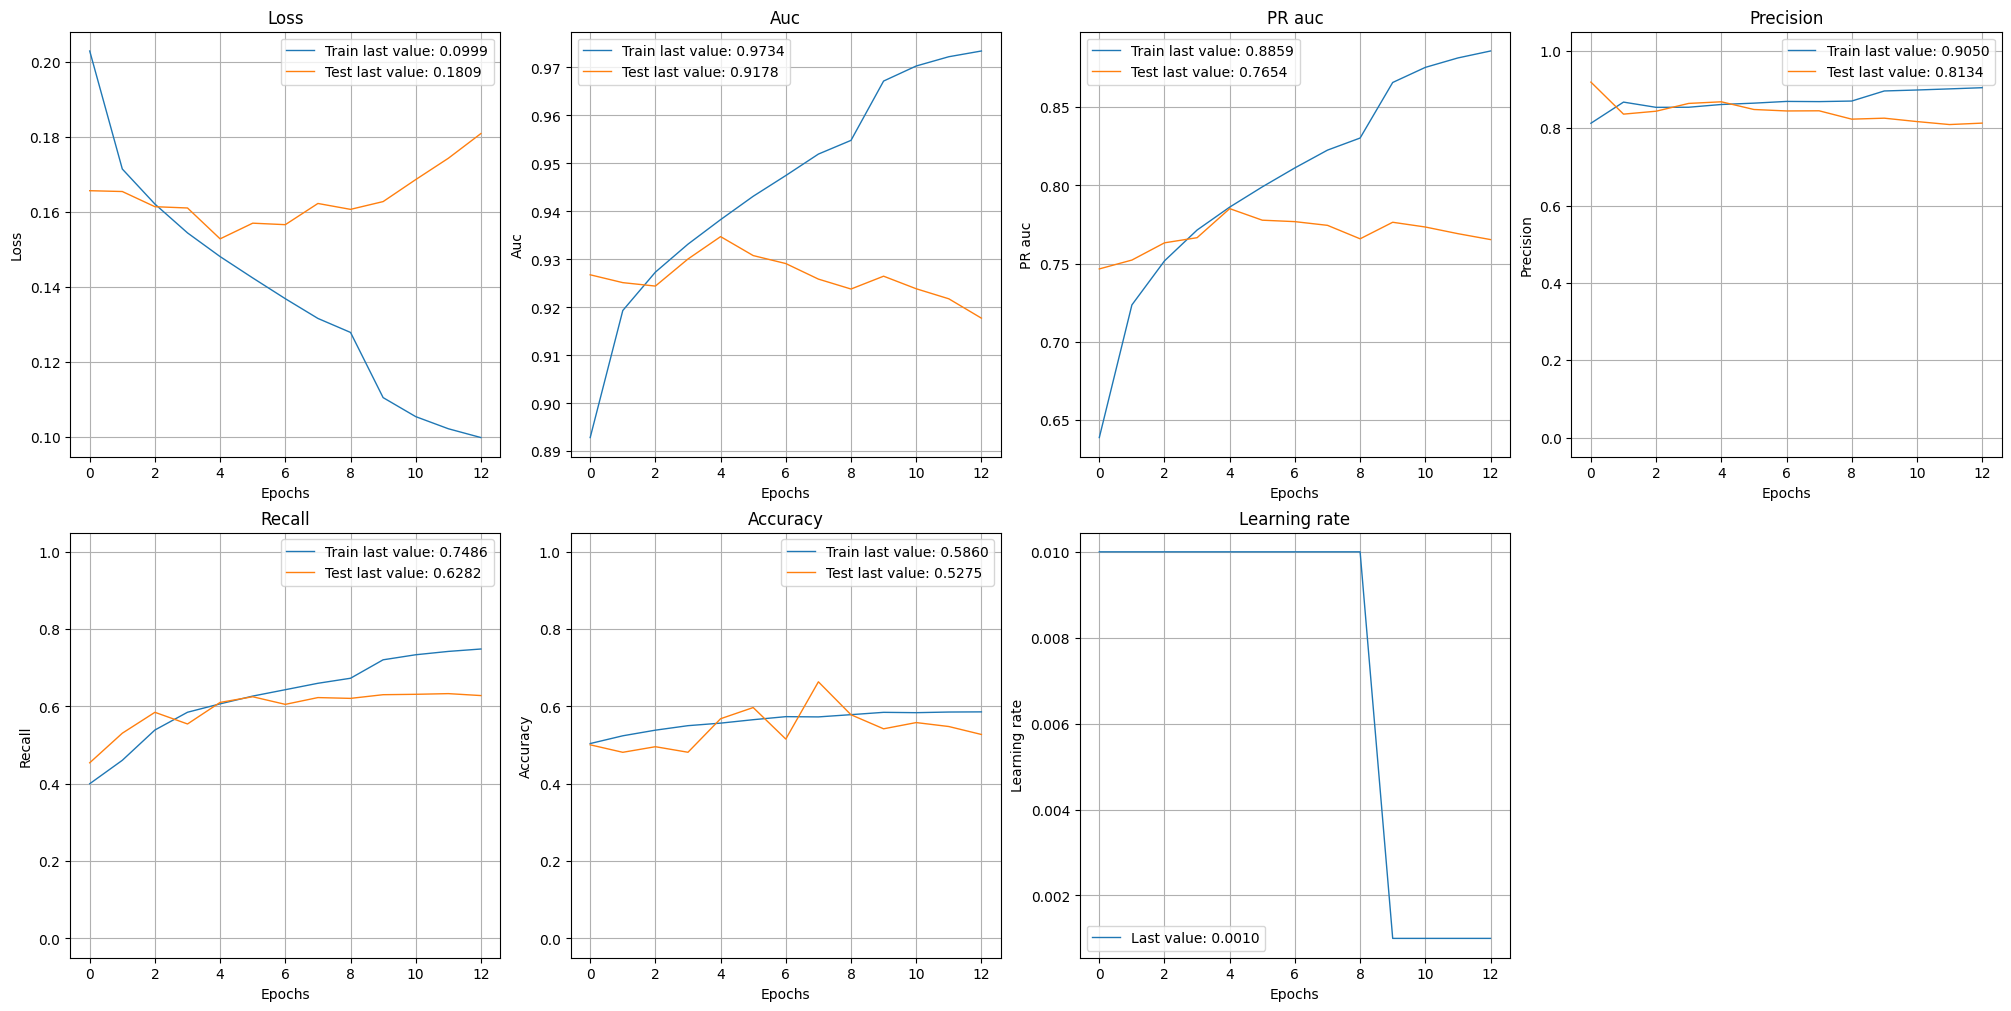

In [95]:
show_history(history)
plot_history(history, path="standard.png")
plt.close()

# Evaluate Model

In [96]:
cat_names = list(test_gen.class_indices.keys())
cat_names.remove('Negative')
cat_names

['CAFOs',
 'Landfills',
 'Mines',
 'ProcessingPlants',
 'RefineriesAndTerminals',
 'WWTreatment']

In [104]:
X_test, y_test = test_gen.next()
y_pred_proba = model.predict(X_test)

16/16 [==============================] - 10s 480ms/step


In [103]:
os.path.exists('./methane_224_data/smallsize224/val_images/val_images/45.34835747746929_-67.89828705144811/naip.png')


True

In [ ]:
# Use that if you want to save the arrays
#np.save(f'y_pred_proba_{RUN_NUMBER}.npy', y_pred_proba)
#np.save(f'y_test_{RUN_NUMBER}.npy', y_test)

## Plot the distribution of a few predictions

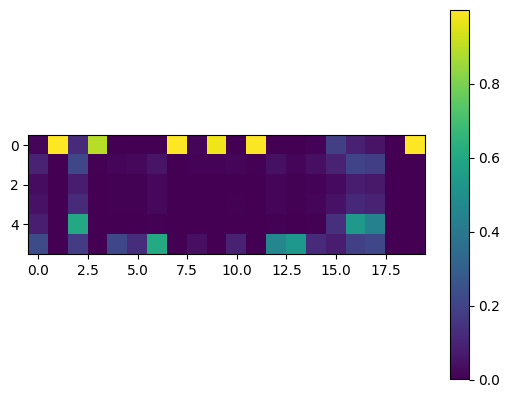

In [105]:
plt.imshow(y_pred_proba[:20].T)
plt.colorbar()
plt.show()

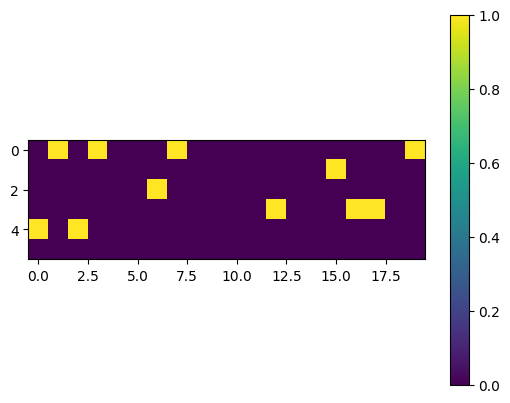

In [106]:
plt.imshow(y_test[:20].T)
plt.colorbar()
plt.show()

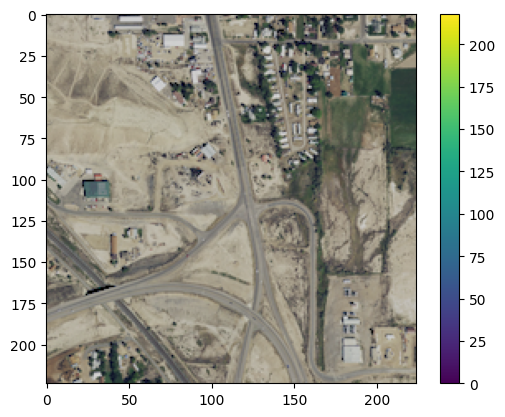

In [107]:
# Plot a sample image from the test set
abc = X_test[0,:,:,:].reshape(224, 224, 3).astype(np.uint8)
plt.imshow(abc)
plt.colorbar()
plt.show()

## Evaluate metrics

In [108]:
# Instantiate metrics
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
auc = tf.keras.metrics.AUC()
pr_auc = tf.keras.metrics.AUC(name='pr_auc', curve='PR')
accuracy = tf.keras.metrics.Accuracy()

In [109]:
# Binarize predictions
y_pred = (y_pred_proba> 0.5).astype(int)

In [110]:
prec_cat = {}
recall_cat = {}
auc_cat = {}
pr_auc_cat = {}
accuracy_cat = {}
overall_cat = {}

def calc_metric(y_test, y_pred, m_dict, m_fun, idx, name):
    m_dict[name] = m_fun(y_test[:][:,idx].reshape(TEST_BATCH_SIZE,1), y_pred[:][:,idx].reshape(TEST_BATCH_SIZE,1)).numpy()

dicts = [prec_cat, recall_cat, auc_cat, pr_auc_cat, accuracy_cat]
funcs = [precision, recall, auc, pr_auc, accuracy]

for idx, name in enumerate(cat_names):
    for m_dict, m_fun in zip(dicts, funcs):
        calc_metric(y_test, y_pred, m_dict, m_fun, idx, name)
    overall_cat[name] = np.mean([d[name] for d in dicts])


In [111]:
metrics_df = pd.DataFrame({
    'Category': cat_names,
    'Precision': list(prec_cat.values()),
    'Recall': list(recall_cat.values()),
    'AUC': list(auc_cat.values()),
    'PR AUC': list(pr_auc_cat.values()),
    'Accuracy': list(accuracy_cat.values()),
    'Overall': list(overall_cat.values())
})

print(metrics_df)

                 Category  Precision    Recall       AUC    PR AUC  Accuracy   
0                   CAFOs   0.636364  0.893617  0.920318  0.590361  0.942000  \
1               Landfills   0.636364  0.466667  0.720147  0.384302  0.928000   
2                   Mines   0.636364  0.325581  0.654038  0.303922  0.926000   
3        ProcessingPlants   0.636364  0.251497  0.619202  0.258239  0.925500   
4  RefineriesAndTerminals   0.711538  0.341014  0.663937  0.341261  0.930800   
5             WWTreatment   0.615385  0.343750  0.661853  0.305770  0.925667   

    Overall  
0  0.796532  
1  0.627096  
2  0.569181  
3  0.538160  
4  0.597710  
5  0.570485  
